In [8]:
from glob import glob
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle
from parcels import ErrorCode, AdvectionRK4_3D, Variable
from parcels.application_kernels.TEOSseawaterdensity import PolyTEOS10_bsq
import gsw

from datetime import timedelta
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt

Connect or disconnect biofields

In [9]:
bio_ON = False

if bio_ON:
    bio_data_path = '/storage/shared/oceanparcels/input_data/MOi/biomer4v2r1/'
    phfiles = sorted(glob(bio_data_path + 'biomer4v2r1-weekly_ph_2019*.nc'))
    mesh_mask_bio = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA025-N006/coordinates.nc'

    filenames_bio = {'ph': {'lon': mesh_mask_bio, 
                              'lat': mesh_mask_bio, 
                              'depth': wfiles[0], 
                              'data': phfiles}}

    variables_bio = {'ph': 'ph'}

    dimensions_bio = {'ph': {'lon': 'glamf', 
                               'lat': 'gphif', 
                               'depth': 'depthw', 
                               'time': 'time_counter'}}
    

In [10]:
# Lorenz - MOi fields
data_path = '/storage/shared/oceanparcels/input_data/MOi/2019/'
# bio_data_path = '/storage/shared/oceanparcels/input_data/MOi/biomer4v2r1/'

output_path = '/storage/shared/oceanparcels/output_data/' + \
    'data_Claudio/backtrack_loc0_column.nc'

ufiles = sorted(glob(data_path + 'psy4v3r1-daily_U_2019*.nc'))
vfiles = sorted(glob(data_path + 'psy4v3r1-daily_V_2019*.nc'))
wfiles = sorted(glob(data_path + 'psy4v3r1-daily_W_2019*.nc'))
tfiles = sorted(glob(data_path + 'psy4v3r1-daily_T_2019*.nc'))    
sfiles = sorted(glob(data_path + 'psy4v3r1-daily_S_2019*.nc'))
twoDfiles = sorted(glob(data_path + 'psy4v3r1-daily_2D_2019*.nc'))

# phfiles = sorted(glob(bio_data_path + 'biomer4v2r1-weekly_ph_2019*.nc'))

mesh_mask = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/coordinates.nc'
bathy_file = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/bathymetry_ORCA12_V3.3.nc'
# mesh_mask_bio = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA025-N006/coordinates.nc'


#### Comparisson between Potential temperature and Conservative temperature

In [4]:
SA = xr.load_dataset(sfiles[0])

In [5]:
temp = xr.load_dataset(tfiles[0])

Text(0.5, 1.0, 'Depth: Surface')

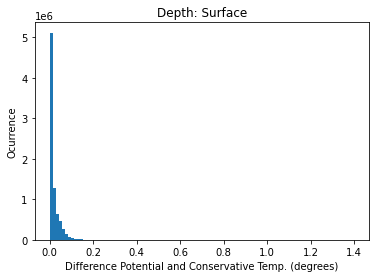

In [6]:
level = 0

# for level in range(50):
cons_temp = gsw.CT_from_pt(SA['vosaline'][level,:,:], temp['votemper'][level, :,:])
diff = abs((temp['votemper'][level,:,:] - cons_temp)).values
diff = np.reshape(diff, diff.shape[0] - diff.shape[1])

plt.hist(diff, bins=100);
plt.xlabel('Difference Potential and Conservative Temp. (degrees)')
plt.ylabel('Ocurrence')
plt.title('Depth: Surface')

In [27]:
diff[~np.isnan(diff)]

array([0.00470708, 0.0045089 , 0.00426873, ..., 0.06739735, 0.06961457,
       0.0741003 ])

In [28]:
np.max(diff[~np.isnan(diff)])

1.4006173674213223

At the surface, the difference between both temperatures is bellow 0.1 degrees, with a maximum difference of up to 1.4 but with few occurreces. 

------

to implement
- sample bathymetry to stop particles once they reach the sea floor
- fix issue with reading files beyond 2019
- rungekutta method


In [11]:
filenames = {'U': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': ufiles},
             'V': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': vfiles},
             'W': {'lon': mesh_mask,
                   'lat': mesh_mask,
                   'depth': wfiles[0],
                   'data': wfiles}}

filenames['cons_temperature'] = {'lon': mesh_mask, 
                                 'lat': mesh_mask, 
                                 'depth': wfiles[0], 
                                 'data': tfiles}
filenames['abs_salinity'] = {'lon': mesh_mask, 
                             'lat': mesh_mask, 
                             'depth': wfiles[0], 
                             'data': sfiles}

filenames['mld'] = {'lon': mesh_mask, 
                     'lat': mesh_mask,
                     'depth': twoDfiles[0],
                     'data': twoDfiles}


In [12]:
n_points = 100
# start_time = datetime.strptime('2007-08-22 12:00:00', '%Y-%m-%d %H:%M:%S')

# start_time = datetime.strptime('2010-12-20 12:00:00', '%Y-%m-%d %H:%M:%S')
start_time = datetime.strptime('2019-12-02 12:00:00', '%Y-%m-%d %H:%M:%S')
# psy4v3r1-daily_2D_2019-01-01.nc

variables = {'U': 'vozocrtx',
             'V': 'vomecrty',
             'W': 'vovecrtz'}

variables['cons_temperature'] = 'votemper'
variables['abs_salinity'] = 'vosaline'
variables['mld'] = 'somxlavt'

dimensions = {'U': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'V': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'},
              'W': {'lon': 'glamf',
                    'lat': 'gphif',
                    'depth': 'depthw',
                    'time': 'time_counter'}}

dimensions['cons_temperature'] = {'lon': 'glamf', 
                                  'lat': 'gphif',
                                  'depth': 'depthw', 
                                  'time': 'time_counter'}

dimensions['abs_salinity'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'depthw', 
                              'time': 'time_counter'}

dimensions['mld'] = {'lon': 'glamf', 
                              'lat': 'gphif',
                              'depth': 'deptht', 
                              'time': 'time_counter'}



In [13]:
indices = {'lat': range(750, 1300), 'lon': range(2900, 4000)}

In [14]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                              allow_time_extrapolation=False,
                              indices=indices)
if bio_ON:
    bio_fieldset = FieldSet.from_nemo(filenames_bio, variables_bio, dimensions_bio)
    fieldset.add_field(bio_fieldset.ph)

         It will be opened with no decoding. Filling values might be wrongly parsed.


In [47]:
fieldset.add_constant('grow_rate', 1e-6)
fieldset.add_constant('g', -9.81)
fieldset.add_constant('viscosity', 1e-6)
fieldset.add_constant('particle_density', 1234)

bathy = xr.load_dataset(bathy_file)

fieldset.add_field(Field('bathymetry', bathy['Bathymetry'].values,
                         lon=bathy['nav_lon'].values, lat=bathy['nav_lat'].values,
                         mesh='spherical'))


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'pydap']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [9]:
class PlasticParticle(JITParticle):
    cons_temperature = Variable('cons_temperature', dtype=np.float32, initial=fieldset.cons_temperature)
    abs_salinity = Variable('abs_salinity', dtype=np.float32, initial=fieldset.abs_salinity)
    mld = Variable('mld', dtype=np.float32, initial=fieldset.mld)
    alpha = Variable('alpha', dtype=np.float32, initial=1e-5)
    density = Variable('density', dtype=np.float32, initial=1035)
    beta = Variable('beta', dtype=np.float32, initial=0)
#     tau_p = Variable('tau_p', dtype=np.float32, initial=0)
    v_s = Variable('v_s', dtype=np.float32, initial=0)
#     if bio_ON:
#         ph = Variable('ph', dtype=np.float32, initial=0)
    

In [10]:
lon_cluster = [6.287]*n_points
lat_cluster = [-32.171]*n_points

# depth_cluster = np.linspace(1, 5000, n_points)
depth_cluster = np.ones(n_points)*2000 #meters

date_cluster = [start_time]*n_points

lon_cluster = np.array(lon_cluster)+(np.random.random(len(lon_cluster))-0.5)/24
lat_cluster = np.array(lat_cluster)+(np.random.random(len(lat_cluster))-0.5)/24

In [11]:
pset = ParticleSet.from_list(fieldset=fieldset, pclass=PlasticParticle,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             depth=depth_cluster,
                             time=date_cluster)


In [12]:
def delete_particle(particle, fieldset, time):
    particle.delete()

In [13]:
def GrowParticle(particle, fieldset, time):
    particle.alpha = particle.alpha - fieldset.grow_rate*particle.dt

In [14]:
def SinkingVelocity(particle, fieldset, time):
    rho_p = fieldset.particle_density ##
    rho_f = particle.density
    nu = filedset.viscosity
    alpha = particle.alpha
    g = fieldset.g
    dt = particle.dt
    
    beta = 3*rho_f/(2*rho_p + rho_f)
    particle.beta = beta
    
    tau_p = alpha*alpha/(3*beta*nu) ## alpha*alpha
    particle.tau_p = tau_p
    
    v_s = (1 - beta)*g*tau_p
    
    
    lon1, lat1 = particle.lon + u1*.5*particle.dt
    (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1, particle]
    lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
    (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2, particle]
    lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
    (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
    particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    
    particle.v_s = v_s
    
    particle.depth = particle.depth + v_s*dt

In [15]:
def SampleField(particle, fielset, time):
    particle.cons_temperature = fieldset.cons_temperature[time, particle.depth, 
                                               particle.lat, particle.lon]
    particle.abs_salinity = fieldset.abs_salinity[time, particle.depth, 
                                               particle.lat, particle.lon]
#     particle.ph = fieldset.ph[time, particle.depth, 
#                                                particle.lat, particle.lon]
    particle.mld = fieldset.mld[time, particle.depth, 
                                               particle.lat, particle.lon]
    
#sample_kernel = pset.Kernel(sample_field)

In [16]:
kernels = pset.Kernel(AdvectionRK4_3D) + pset.Kernel(SampleField) + pset.Kernel(PolyTEOS10_bsq) #+ pset.Kernel(SinkingVelocity)

# Output fileii
output_file = pset.ParticleFile(name=output_path,
                                outputdt=timedelta(hours=24))

pset.execute(kernels,
             output_file=output_file,
             runtime=timedelta(days=10),
             dt=-timedelta(hours=1),
             recovery={ErrorCode.ErrorOutOfBounds: delete_particle})

output_file.close()


sh: None: command not found
INFO: Compiled ArrayPlasticParticleAdvectionRK4_3DSampleFieldPolyTEOS10_bsq ==> /tmp/parcels-263482/libed870d1e26fc360b643032fb9dbef2e2_0.so
INFO: Temporary output files are stored in /storage/shared/oceanparcels/output_data/data_Claudio/out-EIEEIBSY.
INFO: You can use "parcels_convert_npydir_to_netcdf /storage/shared/oceanparcels/output_data/data_Claudio/out-EIEEIBSY" to convert these to a NetCDF file during the run.
100% (864000.0 of 864000.0) |############| Elapsed Time: 0:02:07 Time:  0:02:07


In [17]:
sim = xr.load_dataset(output_path)

In [18]:
sim

<xarray.Dataset>
Dimensions:           (traj: 100, obs: 11)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory        (traj, obs) float64 0.0 0.0 0.0 0.0 ... 99.0 99.0 99.0
    time              (traj, obs) datetime64[ns] 2019-12-02T12:00:00 ... 2019...
    lat               (traj, obs) float64 -32.16 -32.18 -32.2 ... -32.31 -32.32
    lon               (traj, obs) float64 6.267 6.325 6.381 ... 6.813 6.874
    z                 (traj, obs) float64 2e+03 1.997e+03 ... 1.978e+03
    cons_temperature  (traj, obs) float32 2.696 2.71 2.682 ... 2.638 2.637 2.64
    abs_salinity      (traj, obs) float32 34.76 34.76 34.76 ... 34.75 34.75
    mld               (traj, obs) float32 24.93 15.21 13.91 ... 21.1 30.31 42.16
    alpha             (traj, obs) float32 1e-05 1e-05 1e-05 ... 1e-05 1e-05
    density           (traj, obs) float32 1.035e+03 1.028e+03 ... 1.028e+03
    beta              (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    v_s               (traj, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

In [19]:
sim['alpha'][0,1]

<xarray.DataArray 'alpha' ()>
array(1.e-05, dtype=float32)
Attributes:
    long_name:      
    standard_name:  alpha
    units:          unknown

Text(0, 0.5, 'Particle size')

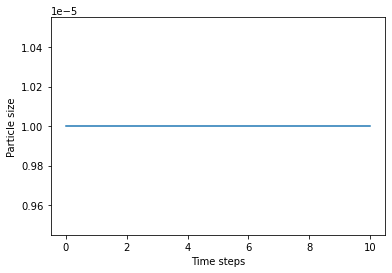

In [19]:
plt.plot(sim['alpha'][0, :])
plt.xlabel('Time steps')
plt.ylabel('Particle size')

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

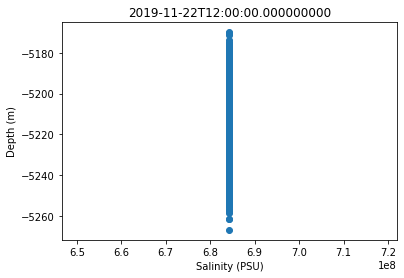

In [24]:
step = 10
plt.scatter(sim['alpha'][:,step], -sim['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

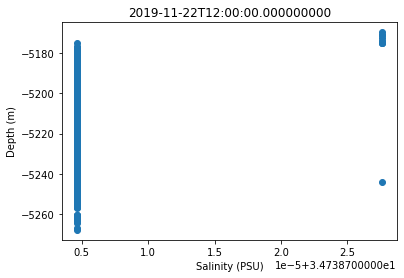

In [19]:
step = 10
plt.scatter(sim['salinity'][:,step], -sim['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

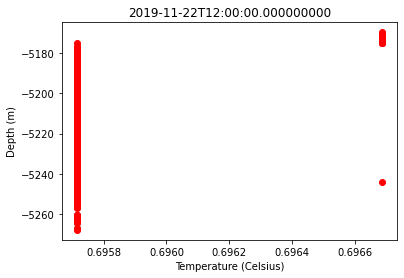

In [20]:
step = 10
plt.scatter(sim['temperature'][:,step], -sim['z'][:,step], color='r')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0.5, 1.0, '2019-11-22T12:00:00.000000000')

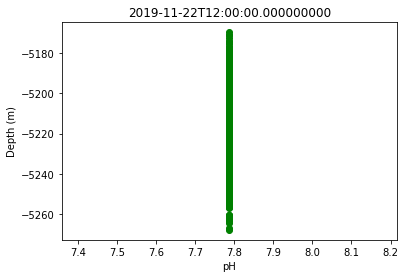

In [21]:
step = 10
plt.scatter(sim['ph'][:,step], -sim['z'][:,step], color='g')
plt.xlabel('pH')
plt.ylabel('Depth (m)')
plt.title(sim['time'][0,step].values)

Text(0, 0.5, 'Latitude')

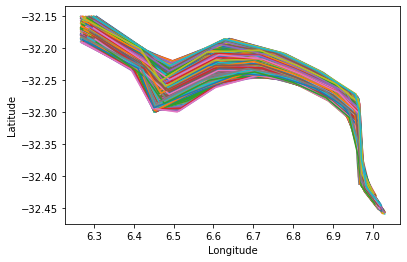

In [23]:
step = 10
for i in range(1000):
    plt.plot(sim['lon'][i,:], sim['lat'][i,:]);

plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title(sim['time'][0,step].values)

In [2]:
sim2 = xr.load_dataset('/storage/shared/oceanparcels/output_data/data_Claudio/backtrack_samplinglocation5170.nc')

In [3]:
sim2

<xarray.Dataset>
Dimensions:      (traj: 10000, obs: 301)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory   (traj, obs) float64 0.0 0.0 0.0 ... 9.999e+03 9.999e+03
    time         (traj, obs) datetime64[ns] 2019-12-02T12:00:00 ... 2019-02-0...
    lat          (traj, obs) float64 -32.16 -32.21 -32.25 ... -31.41 -31.48
    lon          (traj, obs) float64 6.279 6.42 6.479 6.6 ... 6.595 6.516 6.452
    z            (traj, obs) float64 5.17e+03 5.154e+03 ... 5.058e+03 5.057e+03
    temperature  (traj, obs) float32 0.0 0.7206 0.7077 ... 0.763 0.7542 0.7572
    salinity     (traj, obs) float32 0.0 34.74 34.74 34.74 ... 34.74 34.74 34.74
    ph           (traj, obs) float32 0.0 7.789 7.802 7.802 ... 7.804 7.787 7.789
    mld          (traj, obs) float32 0.0 15.49 13.93 17.38 ... 11.01 12.47 10.53
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        v2.3.0-71-g202ef087
    parcels_mesh:           spherical

In [7]:
import cartopy as cart
import cartopy.crs as ccrs
# import cmocean.cm as cmo
# import seaborn as sns
from glob import glob

Text(0, 0.5, 'Latitude')

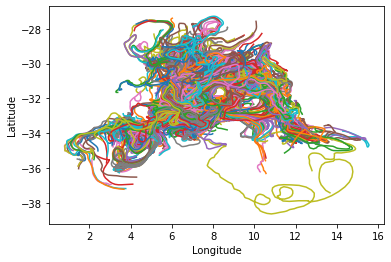

In [4]:
step = 10
for i in range(1000):
    plt.plot(sim2['lon'][i,:], sim2['lat'][i,:]);

plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [45]:
step = 10
plt.scatter(sim2['salinity'][:,step], -sim2['z'][:,step])
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.title(sim2['time'][0,step].values)

KeyError: 'salinity'